In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os


In [12]:

# Set random seed for reproducibility
manualSeed = 999
torch.manual_seed(manualSeed)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
image_size = 64
nz = 100       # Latent vector size
num_classes = 10  # Number of CIFAR-10 classes
batch_size = 128
lr = 0.0002    # Learning rate
beta1 = 0.5    # Beta1 for Adam optimizer
num_epochs = 30

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.CIFAR10(root='./data', download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


Files already downloaded and verified


In [13]:

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator definition
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.init_size = image_size // 4  # Image downsampling
        self.l1 = nn.Sequential(nn.Linear(nz + num_classes, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embedding = self.label_emb(labels)
        gen_input = torch.cat((noise, label_embedding), -1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        return self.conv_blocks(out)

# Discriminator definition
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, 16, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.adv_layer = nn.Sequential(nn.Linear(128 * 4 * 4, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * 4 * 4, num_classes), nn.Softmax(dim=1))

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.size(0), -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)
        return validity, label


Starting Training...
[Epoch 0/30] [Batch 0/391] [D loss: 2.9864535331726074] [G loss: 3.3832509517669678]
[Epoch 0/30] [Batch 100/391] [D loss: 2.818490982055664] [G loss: 2.930269241333008]
[Epoch 0/30] [Batch 200/391] [D loss: 2.409903049468994] [G loss: 2.741551637649536]
[Epoch 0/30] [Batch 300/391] [D loss: 2.5283985137939453] [G loss: 2.611210823059082]
[Epoch 1/30] [Batch 0/391] [D loss: 2.333263874053955] [G loss: 2.5513956546783447]
[Epoch 1/30] [Batch 100/391] [D loss: 2.3936634063720703] [G loss: 2.356607675552368]
[Epoch 1/30] [Batch 200/391] [D loss: 2.406951427459717] [G loss: 2.4566426277160645]
[Epoch 1/30] [Batch 300/391] [D loss: 2.4008235931396484] [G loss: 2.4311366081237793]
[Epoch 2/30] [Batch 0/391] [D loss: 2.3804938793182373] [G loss: 2.828132152557373]
[Epoch 2/30] [Batch 100/391] [D loss: 2.4290952682495117] [G loss: 2.561067581176758]
[Epoch 2/30] [Batch 200/391] [D loss: 2.3563666343688965] [G loss: 2.711362838745117]
[Epoch 2/30] [Batch 300/391] [D loss: 2

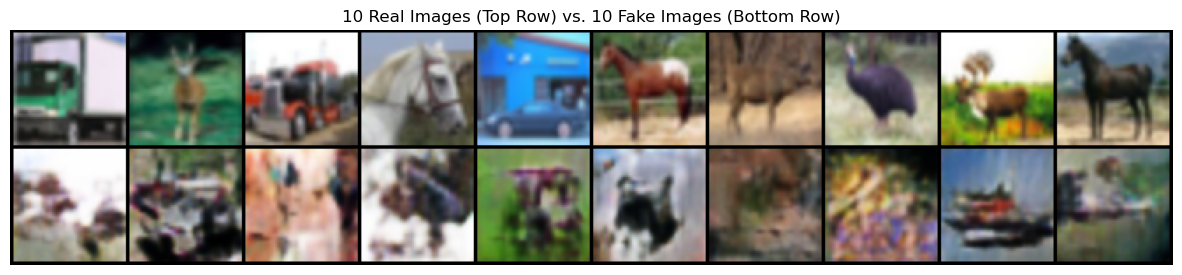

In [14]:

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init)
discriminator.apply(weights_init)

# Loss functions
adversarial_loss = nn.BCELoss()
auxiliary_loss = nn.CrossEntropyLoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Fixed noise for visualization
fixed_noise = torch.randn(10, nz, device=device)
fixed_labels = torch.arange(0, 10, device=device)

# Training loop
print("Starting Training...")
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size = imgs.size(0)
        imgs, labels = imgs.to(device), labels.to(device)

        valid = torch.ones((batch_size, 1), requires_grad=False, device=device)
        fake = torch.zeros((batch_size, 1), requires_grad=False, device=device)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_validity, real_aux = discriminator(imgs)
        d_real_loss = adversarial_loss(real_validity, valid) + auxiliary_loss(real_aux, labels)

        noise = torch.randn(batch_size, nz, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size,), device=device)
        gen_imgs = generator(noise, gen_labels)
        fake_validity, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_validity, fake) + auxiliary_loss(fake_aux, gen_labels)

        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_validity, fake_aux = discriminator(gen_imgs)
        g_loss = adversarial_loss(fake_validity, valid) + auxiliary_loss(fake_aux, gen_labels)
        g_loss.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

# Visualize 10 Real vs. 10 Fake Images
real_imgs, _ = next(iter(dataloader))
real_imgs = real_imgs[:10].to(device)
with torch.no_grad():
    fake_imgs = generator(fixed_noise, fixed_labels).detach()

comparison = torch.cat([real_imgs.cpu(), fake_imgs.cpu()])
plt.figure(figsize=(15, 6))
plt.axis("off")
plt.title("10 Real Images (Top Row) vs. 10 Fake Images (Bottom Row)")
plt.imshow(vutils.make_grid(comparison, nrow=10, normalize=True).permute(1, 2, 0))
plt.show()


In [15]:
from torchvision.transforms import functional as F
from pytorch_fid.fid_score import calculate_fid_given_paths
import os
import shutil

def compute_fid(generator, dataloader, nz, num_classes, device, batch_size=50):
    """
    Compute FID score between real and generated images.

    Args:
        generator (nn.Module): Trained generator model.
        dataloader (DataLoader): Dataloader for the real dataset.
        nz (int): Size of the latent vector for the generator.
        num_classes (int): Number of classes in the dataset.
        device (torch.device): Device (CPU/GPU) to run the computation.
        batch_size (int): Batch size for FID computation.

    Returns:
        float: FID score.
    """
    real_dir = './temp_real_images'
    fake_dir = './temp_fake_images'

    # Ensure directories exist
    os.makedirs(real_dir, exist_ok=True)
    os.makedirs(fake_dir, exist_ok=True)

    # Save real images
    print("Saving real images...")
    counter = 0
    for images, _ in dataloader:
        for img in images:
            img = F.to_pil_image((img * 0.5 + 0.5).clamp(0, 1))  # Convert back to [0, 1] range
            img.save(f'{real_dir}/real_{counter}.png')
            counter += 1
            if counter >= 500:  # Save 500 real images
                break
        if counter >= 500:
            break

    # Generate and save fake images
    print("Generating and saving fake images...")
    noise = torch.randn(500, nz, device=device)
    labels = torch.randint(0, num_classes, (500,), device=device)
    with torch.no_grad():
        fake_images = generator(noise, labels).cpu()
    for i, img in enumerate(fake_images):
        img = F.to_pil_image((img * 0.5 + 0.5).clamp(0, 1))  # Convert back to [0, 1] range
        img.save(f'{fake_dir}/fake_{i}.png')

    # Compute FID score
    print("Computing FID score...")
    fid_value = calculate_fid_given_paths([real_dir, fake_dir], batch_size=batch_size, device=device, dims=2048)

    # Clean up temporary directories
    shutil.rmtree(real_dir)
    shutil.rmtree(fake_dir)

    return fid_value

# Example usage after training
fid_score = compute_fid(generator, dataloader, nz=nz, num_classes=num_classes, device=device)
print(f"FID Score: {fid_score}")


Saving real images...
Generating and saving fake images...
Computing FID score...


100%|██████████| 10/10 [00:00<00:00, 10.27it/s]


FID Score: 148.65473617827672
